# Importing packages

In [1]:
import sys
sys.path.append('/ibex/scratch/gasanoe/fedmix_on_fedjax/src/')

In [2]:
from absl import app

import fedjax
from fedjax.core import tree_util

import jax
import jax.numpy as jnp
import numpy as np

import itertools
import PLM
import FedMix

import time
import pickle

# Computing pure local models (PLM)

In [3]:
fedjax.set_for_each_client_backend('pmap')

In [4]:
train_fd, test_fd = fedjax.datasets.emnist.load_data(only_digits=False)

Reusing cached file '/home/gasanoe/.cache/fedjax/federated_emnist_train.sqlite'
Reusing cached file '/home/gasanoe/.cache/fedjax/federated_emnist_test.sqlite'


In [5]:
model = fedjax.models.emnist.create_conv_model(only_digits=False)

In [6]:
def loss(params, batch, rng):
    # `rng` used with `apply_for_train` to apply dropout during training.
    preds = model.apply_for_train(params, batch, rng)
    # Per example loss of shape [batch_size].
    example_loss = model.train_loss(batch, preds)
    return jnp.mean(example_loss)

In [7]:
grad_fn = jax.jit(jax.grad(loss))

In [8]:
def loss_for_eval(params, batch):
    preds = model.apply_for_eval(params, batch)
    example_loss = model.train_loss(batch, preds)
    return jnp.mean(example_loss)    

In [9]:
grad_fn_eval = jax.jit(jax.grad(loss_for_eval))

In [10]:
client_optimizer = fedjax.optimizers.sgd(learning_rate=10**(-1.5))
# Hyperparameters for client local traing dataset preparation.
client_batch_hparams = fedjax.ShuffleRepeatBatchHParams(batch_size=20, num_epochs=200, drop_remainder=True)

algorithm = PLM.computing_plm(grad_fn, client_optimizer, client_batch_hparams)

In [11]:
# Initialize model parameters and algorithm server state.
init_params = model.init(jax.random.PRNGKey(17))

In [12]:
server_state = algorithm.init(init_params)

In [13]:
rng = jax.random.PRNGKey(1)

In [14]:
save_file = '../results/PLM_emnist.pickle'

In [ ]:
time_begin = time.time()
rng = jax.random.PRNGKey(10)
num_client = 0
for client_id, cds in train_fd.clients():
    rng, use_rng = jax.random.split(rng)
    server_state, _ = algorithm.apply(server_state, [(client_id, cds, use_rng)])
    num_client += 1
    print('{} clients out of {} are processed.'.format(num_client, train_fd.num_clients()), end='\r')
    if num_client % 50 == 0:
        with open(save_file, 'wb') as handle:
            pickle.dump(server_state.PLM, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Total time spent on the task = {}'.format(time.time() - time_begin))

In [15]:
with open(save_file, 'rb') as handle:
    PLM_dict = pickle.load(handle)

# Statistics

In [16]:
grads = []

In [17]:
grads

[]

In [19]:
train_client_sampler = fedjax.client_samplers.UniformGetClientSampler(fd=train_fd, num_clients=8, seed=0)

In [20]:
for round_num in range(1, 26):
    clients = train_client_sampler.sample()
    for client_id, cds, _ in clients:
        grad_ = grad_fn_eval(PLM_dict[client_id], train_fd.get_client(client_id).all_examples())
        grads.append(tree_util.tree_l2_norm(grad_))
    print('Round {} / {}'.format(round_num, 25), end='\r')

In [23]:
from matplotlib import pyplot as plt

In [25]:
grad_ex = grads[0]

In [27]:
grads_np = np.array(grads)

(array([ 4.,  5.,  5.,  8.,  7.,  5.,  7.,  8., 11., 17.,  9., 12., 15.,
        23., 15., 18., 14., 12.,  2.,  3.]),
 array([-2.7654657 , -2.641248  , -2.5170305 , -2.3928127 , -2.268595  ,
        -2.1443775 , -2.0201597 , -1.8959421 , -1.7717245 , -1.6475068 ,
        -1.5232891 , -1.3990715 , -1.2748538 , -1.1506362 , -1.0264184 ,
        -0.9022008 , -0.7779832 , -0.6537655 , -0.52954787, -0.40533018,
        -0.28111252], dtype=float32),
 <BarContainer object of 20 artists>)

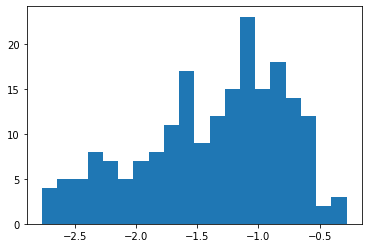

In [31]:
plt.hist(np.log10(grads_np), bins=20)